# Inspector

Inspecting the generated ASTs.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import json
import os
import joblib
from operator import itemgetter
import networkx as nx
from networkx.readwrite import json_graph
import matplotlib.colors as mcolors
import collections

In [2]:
DATA_PATH = 'data/keras-example/graph/'

In [3]:
PREFIX = 'keras'

## Load data

### Features

In [4]:
feats = np.load(DATA_PATH+PREFIX+'-feats.npy')
feats.shape

(212424, 104)

### Classes

In [5]:
class_map = json.load(open(DATA_PATH+PREFIX+"-class_map.json"))

### Graph

In [6]:
G_data = json.load(open(DATA_PATH+PREFIX+ "-G.json"))
G = json_graph.node_link_graph(G_data)
print(G.number_of_nodes(), G.number_of_edges())

212424 318631


### Node id map

In [7]:
node_id_map = json.load(open(DATA_PATH+PREFIX+"-id_map.json"))

### File map

In [8]:
file_map = json.load(open(DATA_PATH+PREFIX+"-file_map.json"))

### Source-code line map

In [9]:
source_map = json.load(open(DATA_PATH+PREFIX+"-source_map.json"))

### Parse map

In [10]:
parse_map = json.load(open(DATA_PATH+PREFIX+"-parse_map.json"))

### AST Token maps

In [11]:
#ast_symbol_dict = joblib.load(filename='ast_symbol_dict')
inv_ast_symbol_dict = joblib.load(filename='inv_ast_symbol_dict')

In [12]:
from _ast import *
import sys

MOD_SYMBOLS = [Module, Interactive, Expression, Suite]
STMT_SYMBOLS = [FunctionDef, AsyncFunctionDef, ClassDef, Return, Delete, \
                Assign, AugAssign, For, AsyncFor, While, If, With, AsyncWith, \
                Raise, Try, Assert, Import, ImportFrom, Global, Nonlocal, \
                Expr, Pass, Break, Continue]
EXPR_SYMBOLS = [BoolOp, BinOp, UnaryOp, Lambda, IfExp, Dict, Set, ListComp, \
                SetComp, DictComp, GeneratorExp, Await, Yield, YieldFrom, \
                Compare, Call, Num, Str, FormattedValue, JoinedStr, Bytes, \
                NameConstant, Ellipsis, Constant, Attribute, Subscript, \
                Starred, Name, List, Tuple]
EXPR_CONTENT_SYMBOLS = [Load, Store, Del, AugLoad, AugStore, Param]
SLICE_SYMBOLS = [Slice, ExtSlice, Index]
BOOLOP_SYMBOLS = [And, Or]
OPERATOR_SYMBOLS = [Add, Sub, Mult, MatMult, Div, Mod, Pow, LShift, RShift, \
                    BitOr, BitXor, BitAnd, FloorDiv]
UNARYOP_SYMBOLS = [Invert, Not, UAdd, USub]
CMPOP_SYMBOLS = [Eq, NotEq, Lt, LtE, Gt, GtE, Is, IsNot, In, NotIn]
COMPREHENSION_SYMBOLS = [comprehension]
EXCEPT_SYMBOLS = [excepthandler, ExceptHandler]
ARG_SYMBOLS = [arguments, arg, keyword]
IMPORT_SYMBOLS = [alias, withitem]
PYTHON_SYMBOLS = MOD_SYMBOLS + STMT_SYMBOLS + EXPR_SYMBOLS \
               + EXPR_CONTENT_SYMBOLS + SLICE_SYMBOLS \
               + BOOLOP_SYMBOLS + OPERATOR_SYMBOLS \
               + UNARYOP_SYMBOLS + CMPOP_SYMBOLS \
               + EXCEPT_SYMBOLS + ARG_SYMBOLS + IMPORT_SYMBOLS \
               + COMPREHENSION_SYMBOLS
AST_SYMBOL_DICT = dict((v, k) for (k, v) in enumerate(PYTHON_SYMBOLS))

In [13]:
AST_SYMBOL_DICT

{_ast.Module: 0,
 _ast.Interactive: 1,
 _ast.Expression: 2,
 _ast.Suite: 3,
 _ast.FunctionDef: 4,
 _ast.AsyncFunctionDef: 5,
 _ast.ClassDef: 6,
 _ast.Return: 7,
 _ast.Delete: 8,
 _ast.Assign: 9,
 _ast.AugAssign: 10,
 _ast.For: 11,
 _ast.AsyncFor: 12,
 _ast.While: 13,
 _ast.If: 14,
 _ast.With: 15,
 _ast.AsyncWith: 16,
 _ast.Raise: 17,
 _ast.Try: 18,
 _ast.Assert: 19,
 _ast.Import: 20,
 _ast.ImportFrom: 21,
 _ast.Global: 22,
 _ast.Nonlocal: 23,
 _ast.Expr: 24,
 _ast.Pass: 25,
 _ast.Break: 26,
 _ast.Continue: 27,
 _ast.BoolOp: 28,
 _ast.BinOp: 29,
 _ast.UnaryOp: 30,
 _ast.Lambda: 31,
 _ast.IfExp: 32,
 _ast.Dict: 33,
 _ast.Set: 34,
 _ast.ListComp: 35,
 _ast.SetComp: 36,
 _ast.DictComp: 37,
 _ast.GeneratorExp: 38,
 _ast.Await: 39,
 _ast.Yield: 40,
 _ast.YieldFrom: 41,
 _ast.Compare: 42,
 _ast.Call: 43,
 _ast.Num: 44,
 _ast.Str: 45,
 _ast.FormattedValue: 46,
 _ast.JoinedStr: 47,
 _ast.Bytes: 48,
 _ast.NameConstant: 49,
 _ast.Ellipsis: 50,
 _ast.Constant: 51,
 _ast.Attribute: 52,
 _ast.Subscr

---

## Helpers

In [14]:
def get_name_from_token(token, show_id=True):
    tokenid  = np.nonzero(token)[0][0]
    return get_name_from_token_id(tokenid, show_id=show_id)

In [15]:
def get_name_from_token_id(tokenid, show_id = True):
    strtoken = inv_ast_symbol_dict.get(tokenid)
    
    if strtoken is None:
        if tokenid == 104:
            strtoken = "Root Node"
        else:
            strtoken = "<Unknown token>"
    else:
        strtoken = strtoken.__name__
        
    if show_id is True:
        strtoken += " " + str(tokenid) 
        
    return strtoken

In [16]:
def inspect_node_recursive(node_id, G, feats, depth=0):
    '''
    Recursively print neighbouring node tokens
    '''
    neighbours = list(G.adj[node_id])
    for n in neighbours:
        strtoken = get_name_from_token(feats[n])
        if strtoken=="Root Node 104":
            print(n)
        print(" "*depth, strtoken)
        if depth < 2:
            inspect_node_recursive(n, G, feats, depth+1)

In [17]:
# Example usage
inspect_node_recursive(0, G=G, feats=feats)

 Expr 24
  Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Try 18
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Module 0
  Str 45
   Expr 24
 ImportFrom 21
  Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Try 18
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Module 0
  alias 101
   ImportFrom 21
 ImportFrom 21
  Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   

   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   Import 20
   Import 20
   Import 20
   Import 20
   Import 20
   Import 20
   Import 20
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Try 18
   ClassDef 6
   ClassDef 6
   ClassDef 6
   ClassDef 6
   ClassDef 6
   ClassDef 6
   ClassDef 6
   ClassDef 6
   ClassDef 6
   ClassDef 6
   ClassDef 6
   ClassDef 6
   ClassDef 6
   ClassDef 6
   Module 0
  Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ClassDef 6
   ClassDef 6
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Module 0
  Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ClassDef 6
   ClassDef 6
   ClassDef 6
   ClassDef 6
   ClassDef 6
   Assign 9
   Assign 9
  

   ClassDef 6
   ClassDef 6
   ClassDef 6
   ClassDef 6
   ClassDef 6
   ClassDef 6
   ClassDef 6
   ClassDef 6
   ClassDef 6
   ClassDef 6
   ClassDef 6
   ClassDef 6
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Module 0
  Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ClassDef 6
   ClassDef 6
   ClassDef 6
   Module 0
  Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Impor

   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Module 0
  Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ClassDef 6
   FunctionDef 4
   Module 0
  Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ClassDef 6
   ClassDef 6
   ClassDef 6
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Module 0
  Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   Import 20
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFro

   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Module 0
  Module 0
   Import 20
   ImportFrom 21
   Import 20
   Import 20
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   Assign 9
   Try 18
   Try 18
   Try 18
   Assign 9
   FunctionDef 4
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   ClassDef 6
   If 14
   Module 0
  Module 0
   Import 20
   Import 20
   Import 20
   Import 20
   ImportFrom 21
   Import 20
   Import 20
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFr

   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Expr 24
   Expr 24
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Expr 24
   Expr 24
   Assign 9
   Assign 9
   If 14
   Module 0
  Module 0
   Expr 24
   ImportFrom 21
   Import 20
   Import 20
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Expr 24
   Assign 9
   With 15
   Expr 24
   Expr 24
   Assign 9
   Assign 9
   Assign 9
   For 11
   Expr 24
   Assign 9
   Expr 24
   Assign 9
   Assign 9
   Expr 24
   Assign 9
   Assign 9
   Expr 24
   Expr 24
   Assign 9
   Expr 24
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Expr 24
   Assign 9
   Assign 9
   For 11
   Assign 9
   Expr 24
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 

   Assign 9
   Expr 24
   Expr 24
   Expr 24
   Assign 9
   Assign 9
   Expr 24
   Expr 24
   Expr 24
   Assign 9
   Expr 24
   Expr 24
   Expr 24
   Expr 24
   Expr 24
   Expr 24
   Assign 9
   Expr 24
   Expr 24
   Module 0
  Module 0
   Expr 24
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   AugAssign 10
   AugAssign 10
   Expr 24
   Expr 24
   Expr 24
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Expr 24
   Expr 24
   Assign 9
   Expr 24
   Expr 24
   Module 0
  Module 0
   Expr 24
   Import 20
   Import 20
   Import 20
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   If 14
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign

In [18]:
def draw_egonet(node_id=1009, radius=2):
    node_and_degree = G.degree()
    hub_ego = nx.ego_graph(G, node_id, radius=radius)
    # Draw graph
    pos = nx.spring_layout(hub_ego)

    neighbours = list(hub_ego.nodes())
    labels = {}
    for n in neighbours:
        labels[n] = get_name_from_token(feats[n], show_id=False)

    nx.draw(hub_ego, pos, node_color='b', node_size=50, with_labels=True, labels=labels)
    # Draw ego as large and red
    nx.draw_networkx_nodes(hub_ego, pos, nodelist=[node_id], node_size=300, node_color='r')
    plt.show()
    return neighbours

/dfs/scratch0/dtsbourg/SAGE-fmt/py37/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


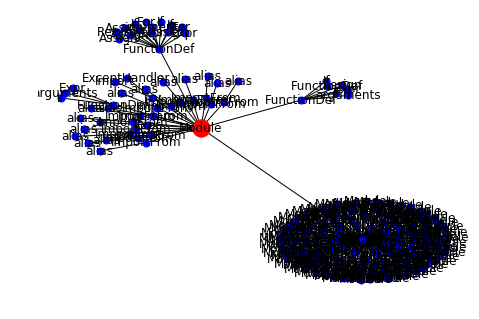

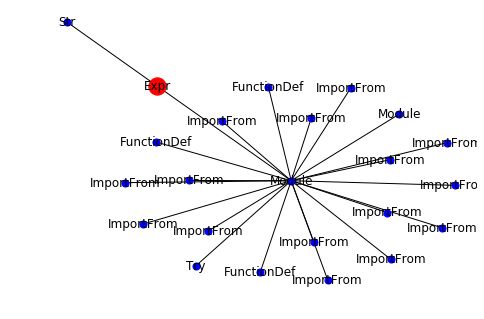

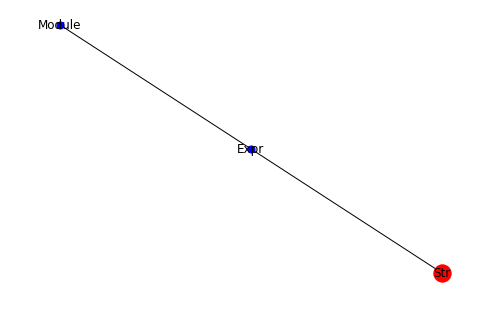

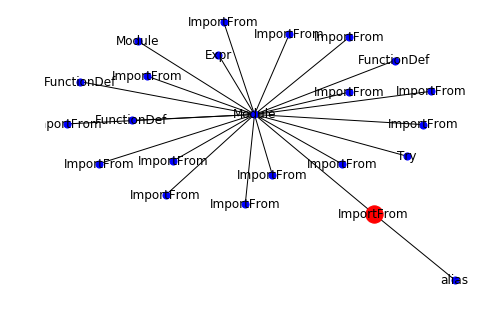

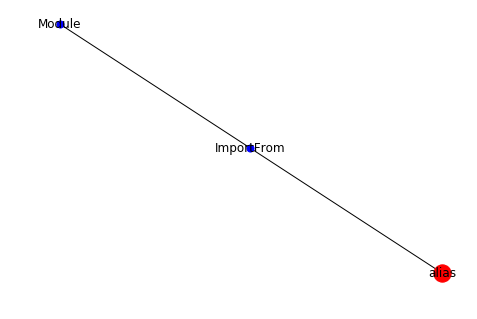

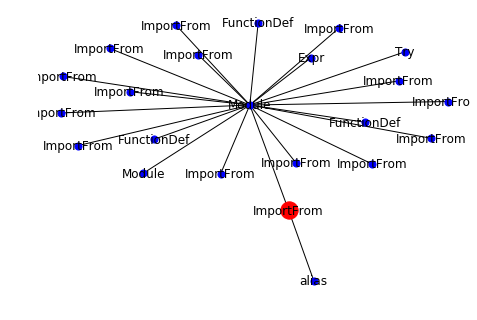

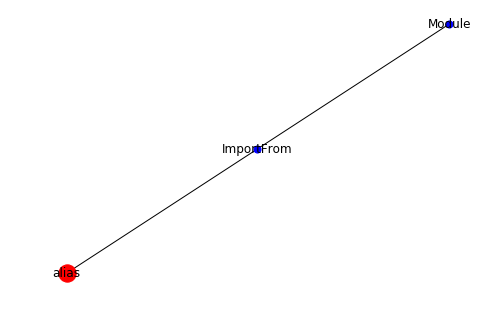

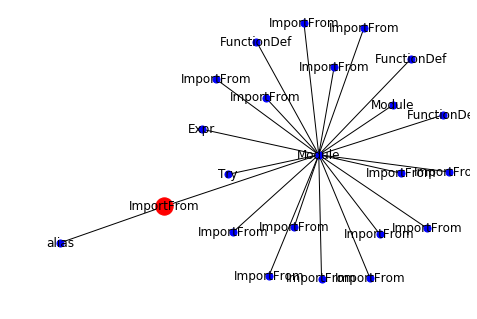

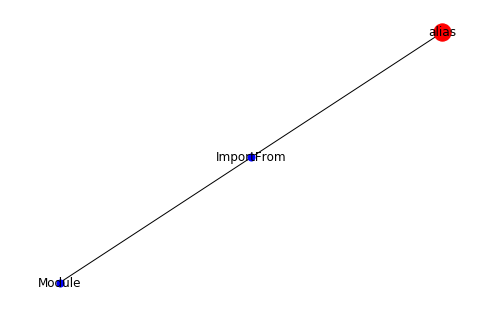

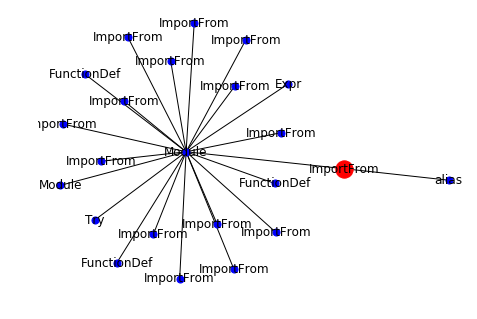

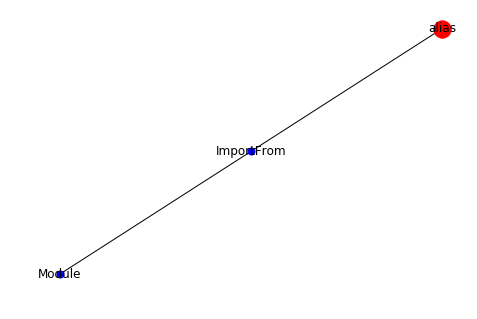

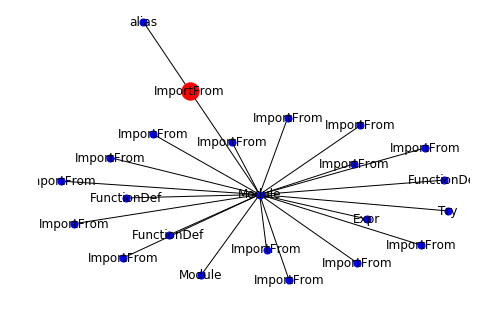

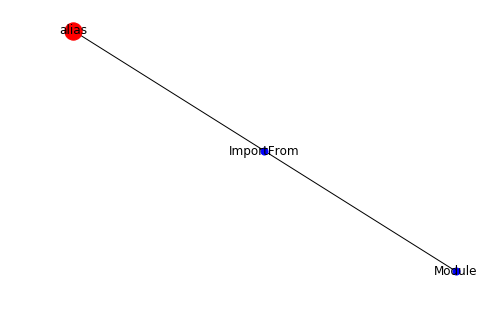

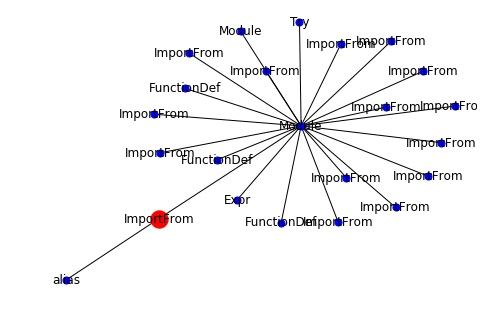

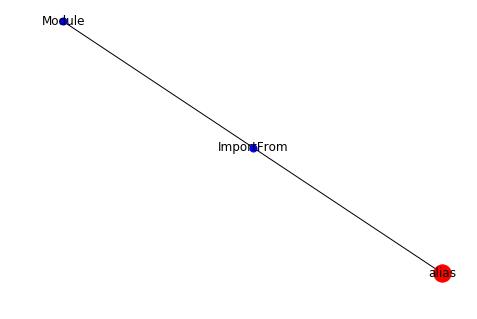

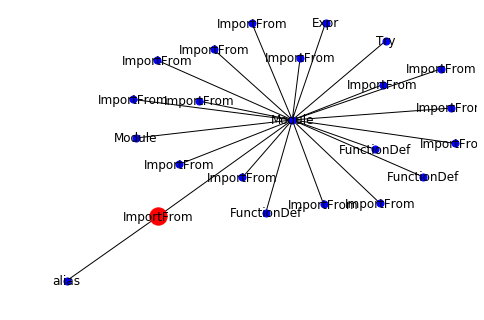

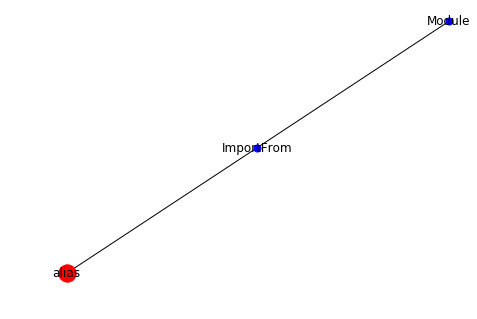

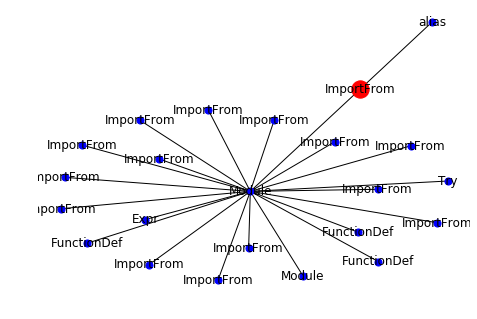

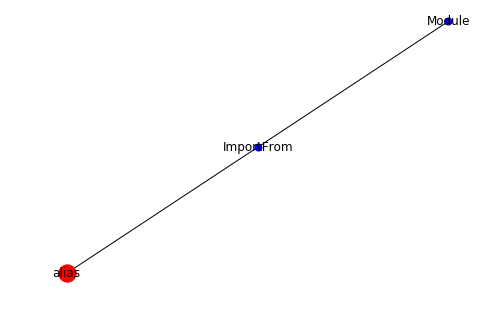

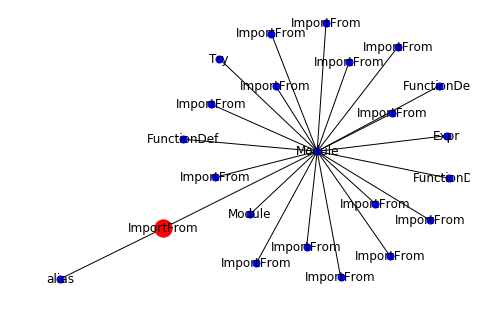

In [19]:
# Example usage 
for i in range(20):
    draw_egonet(i, radius=2)

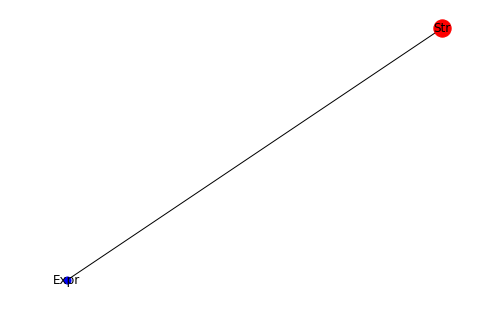

[1, 2]

In [20]:
example_root_node_id = 2
draw_egonet(example_root_node_id, radius=1)

In [21]:
if G.number_of_nodes() < 100:
    labels = {}
    for n in G.nodes():
        labels[n] = get_name_from_token(feats[n], show_id=False)
    pos = nx.layout.kamada_kawai_layout(G)
    nx.draw(G, pos, node_color='g', node_size=250, with_labels=True, labels=labels)

In [22]:
def get_code_token(node_id):
    top_node, lineno, col_offset = source_map[str(node_id)]
    
    print("node_id =",node_id, "; top_node =",top_node)
    print("token_type =", get_name_from_token(feats[G.nodes()][node_id], show_id=False))


    ast_filename = file_map[str(top_node)]
    source_filename = parse_map[ast_filename]
    
    print()
    
    with open(source_filename[3:]) as f:
        for i, line in enumerate(f):
            if i+1 == lineno:
                print("Line", lineno, ":") 
                print("`", line.strip('\n'),"`")
                if col_offset != -1:
                    l = 0
                    for ls in line.split(): 
                        l += len(ls)
                        if l > col_offset:
                            print("\nToken =",ls)
                            break

In [23]:
get_code_token(1)

node_id = 1 ; top_node = 0
token_type = Expr

Line 2 :
` """ `


---

## Graph analysis

In [149]:
def draw_color_graph(G, measure):
    plt.figure(figsize=(15,15))
    pos = nx.layout.kamada_kawai_layout(G)
    labels = {}
    for n in G.nodes():
        labels[n] = get_name_from_token(feats[n], show_id=False)
    measures = color_list = [v for v in measure(G).values()]
    measure_name = measure.__name__
    
    nodes = nx.draw_networkx_nodes(G, pos, node_size=500, cmap=plt.cm.plasma, 
                                   node_color=measures,
                                   nodelist=G.nodes())
    
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
    
    # labels = nx.draw_networkx_labels(G, pos)
    edges = nx.draw_networkx_edges(G, pos)
    
    pos_labels = {}
    x_off, y_off = 0.05, 0.05

    for k, v in pos.items():
        pos_labels[k] = (v[0]+x_off, v[1]+y_off)
    
    nx.draw_networkx_labels(G,pos_labels,labels,font_size=16)
    
    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()

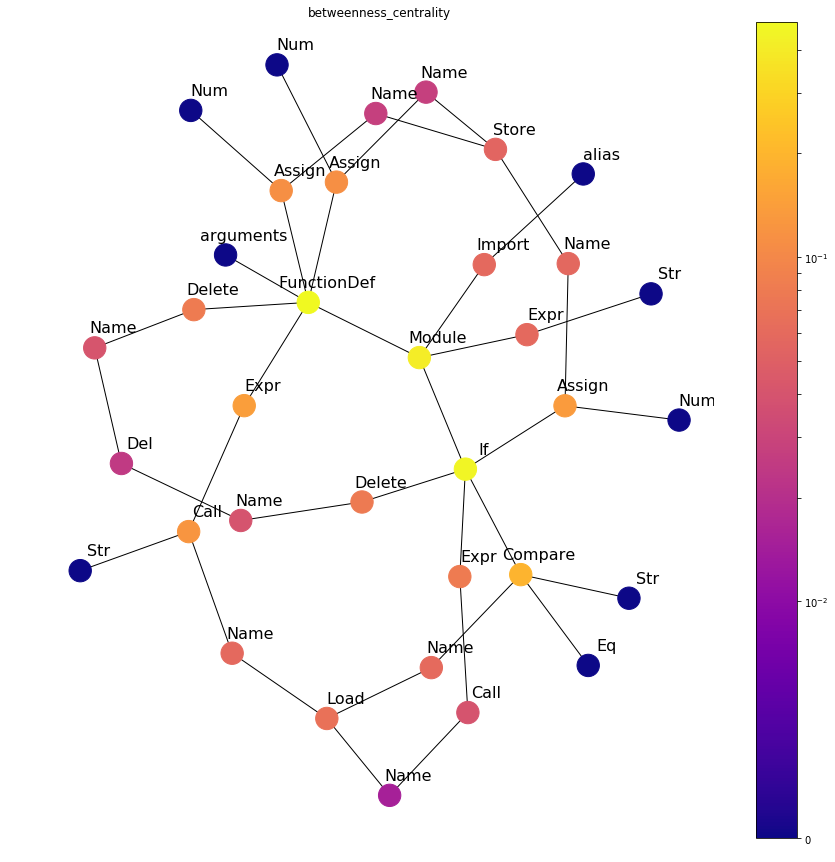

In [150]:
if G.number_of_nodes() < 100:
    draw_color_graph(G, nx.betweenness_centrality)

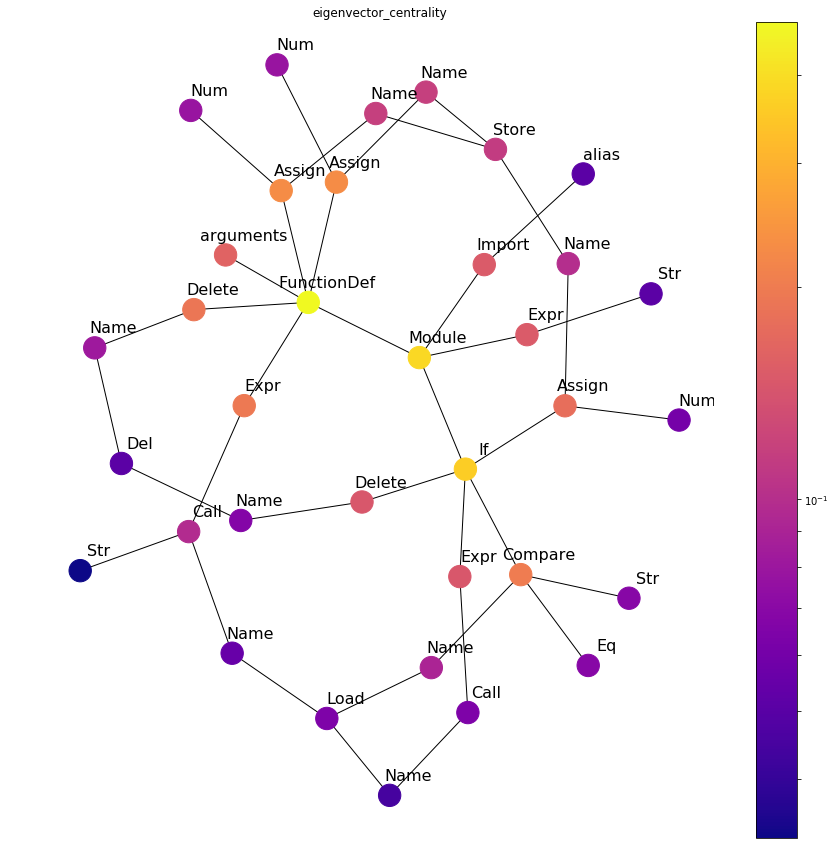

In [151]:
if G.number_of_nodes() < 100:
    draw_color_graph(G, nx.eigenvector_centrality)

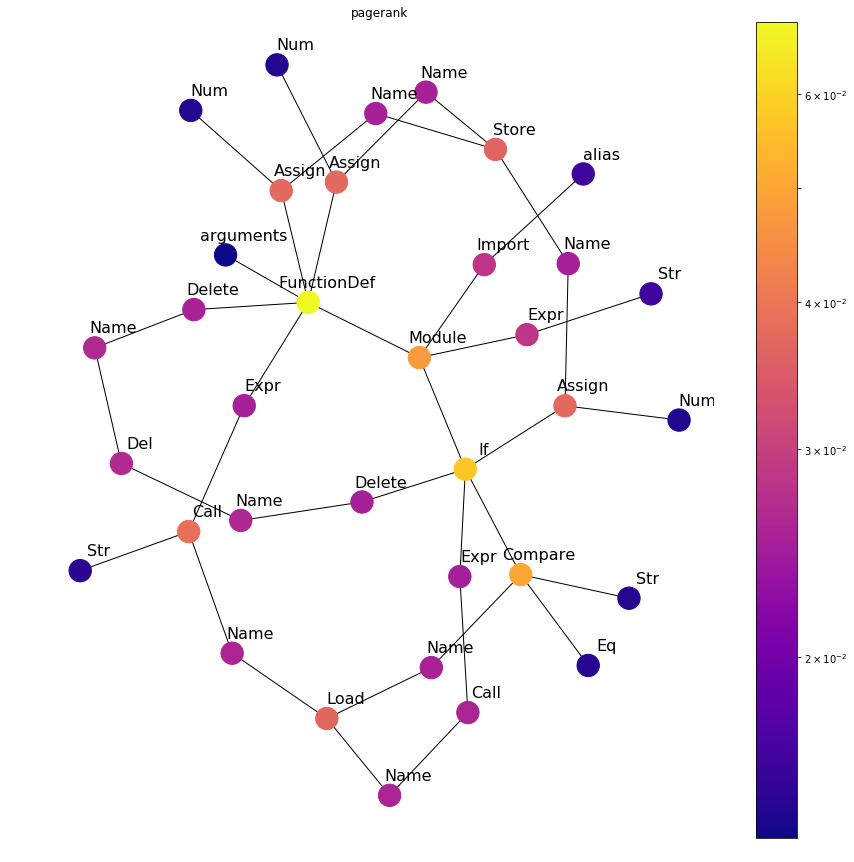

In [152]:
if G.number_of_nodes() < 100:
    draw_color_graph(G, nx.pagerank)

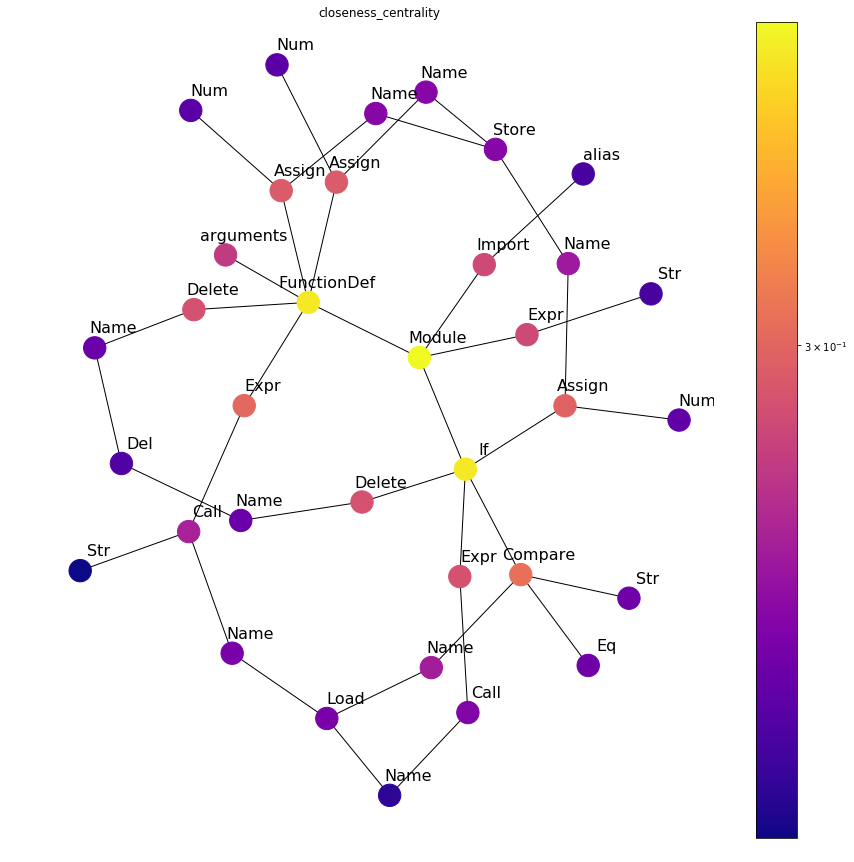

In [153]:
if G.number_of_nodes() < 100:
    draw_color_graph(G, nx.closeness_centrality)

---

## Graph Metrics

### Node degree distribution

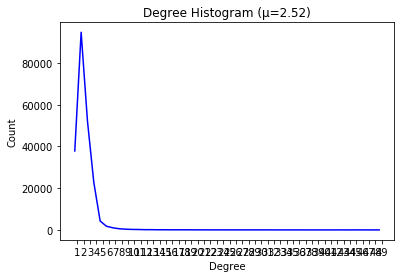

In [24]:
degree_sequence = sorted([d for n, d in G.degree() if d < 50], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

mean_degree = sum(degree_sequence)/G.number_of_nodes()


fig, ax = plt.subplots()
plt.plot(deg, cnt, color='b')

plt.title("Degree Histogram (µ="+"{:.2f}".format(mean_degree)+")")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

plt.show()

In [125]:
degreeCount

Counter({4112: 1,
         3898: 1,
         3850: 1,
         3517: 1,
         2957: 1,
         2814: 1,
         2084: 1,
         1976: 1,
         1730: 1,
         1692: 1,
         1623: 1,
         1612: 1,
         1551: 1,
         1537: 1,
         1532: 1,
         1483: 1,
         1466: 1,
         1406: 1,
         1384: 1,
         1361: 1,
         1188: 1,
         1028: 1,
         954: 1,
         940: 1,
         932: 1,
         927: 1,
         907: 1,
         902: 1,
         894: 1,
         893: 1,
         892: 1,
         853: 1,
         769: 1,
         768: 1,
         743: 1,
         738: 1,
         726: 1,
         688: 1,
         686: 1,
         685: 1,
         631: 1,
         608: 1,
         600: 1,
         558: 1,
         550: 1,
         539: 1,
         531: 1,
         521: 1,
         518: 1,
         515: 1,
         510: 1,
         509: 1,
         508: 1,
         507: 1,
         502: 1,
         468: 1,
         462: 1,
         

### Diameter

In [38]:
diams = nx.diameter(G)

KeyboardInterrupt: 

### Eccentricity

In [122]:
ecc_count = collections.Counter(nx.eccentricity(G).values())
deg, cnt = zip(*ecc_count.items())

mean_ecc = sum(nx.eccentricity(G).values())/G.number_of_nodes()

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Eccentricity Histogram (µ="+"{:.2f}".format(mean_ecc)+")")
plt.ylabel("Count")
plt.xlabel("Eccentricity")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

plt.show()

KeyboardInterrupt: 

## Graph subsampling

In [33]:
G_filt = nx.Graph()
G_filt.add_nodes_from([n for n, d in G.degree() if d < 50])

In [34]:
G_filt.add_edges_from([edge for edge in G.edges if ((edge[0] in G_filt.nodes) and (edge[1] in G_filt.nodes))])

In [35]:
G_filt.number_of_nodes(), G_filt.number_of_edges()

(216887, 221660)

In [36]:
G.number_of_nodes(), G.number_of_edges()

(217178, 326003)

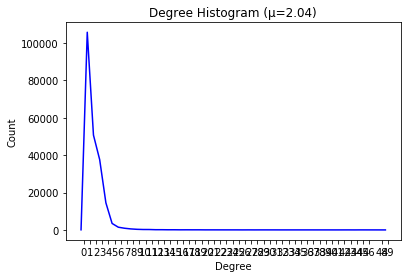

In [37]:
degree_sequence = sorted([d for n, d in G_filt.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

mean_degree = sum(degree_sequence)/G.number_of_nodes()


fig, ax = plt.subplots()
plt.plot(deg, cnt, color='b')

plt.title("Degree Histogram (µ="+"{:.2f}".format(mean_degree)+")")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

plt.show()

## Feature distribution

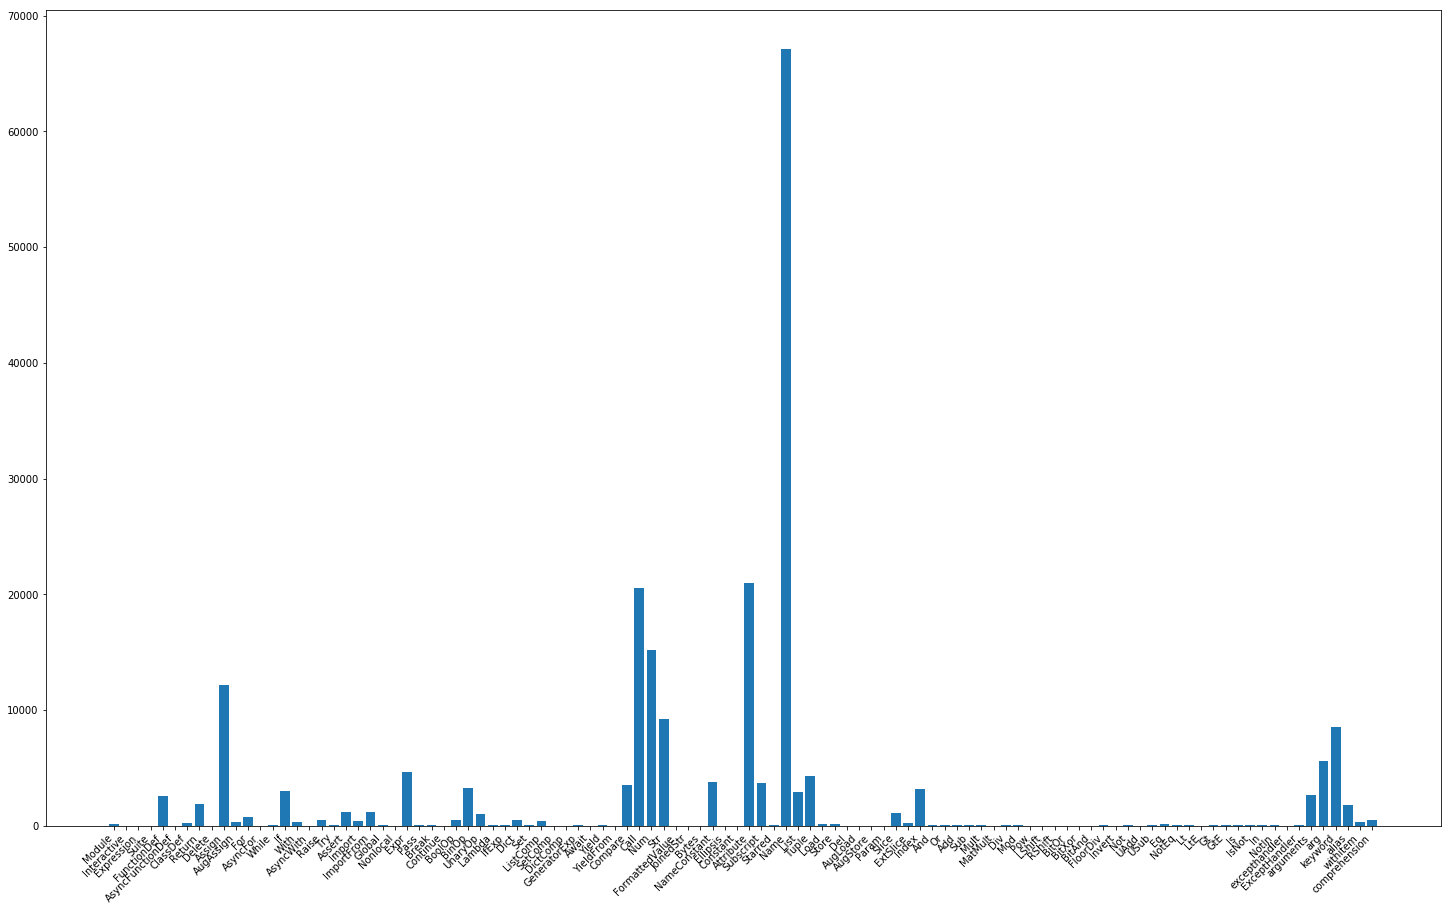

In [70]:
plt.figure(figsize=(25,15))
plt.bar(range(104),feats.sum(axis=0));
plt.xticks(range(104),[_.__name__ for _ in PYTHON_SYMBOLS],rotation=45, ha="right");

In [66]:
from collections import Counter

classes = [0]*14
for k,v in class_map.items():
    classes[v] += class_map[k]

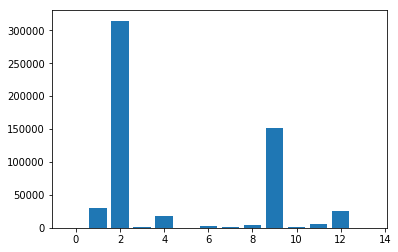

In [69]:
plt.bar(range(14),classes);

In [ ]:
plt.figure(figsize=(25,15))
plt.bar(range(104),feats.sum(axis=0));
plt.xticks(range(104),PYTHON_SYMBOLS,rotation=45, ha="right");